### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants

In [8]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [8]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [10]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [22]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [23]:
base_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [13]:
# history = base_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=(dev_input,y_dev),
#                          callbacks=[earlystop])

In [14]:
# base_embed_model.save("cate_embed_base_model.h5")

In [15]:
base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

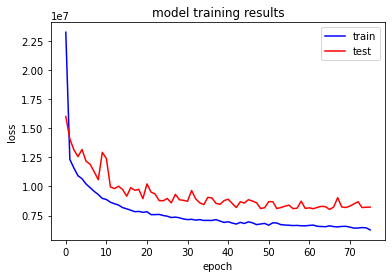

In [66]:
# plot_metrics(history,"loss")

In [67]:
# plot_metrics(history,"MAPE")

### Let's check model results 

In [17]:
regression_metrics(base_embed_model,train_input,y_train,test_input,y_test,256)

r2_score         rmse  price_diff_abs_max
train  0.943838  2337.606449          695.343624
test   0.937741  2406.883565          408.698918

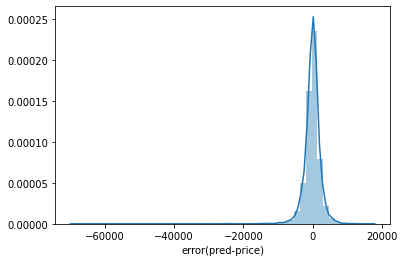

In [18]:
plot_pred_price(base_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [19]:
price_table = price_diff(base_embed_model,X_test,y_test,256, 1, test_input)

In [20]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

model transmission fuelType  binned_year  mil_cat  binned_mpg  \
39978    A Class       Manual   Petrol            1        5           1   
40171    A Class    Automatic   Petrol            1        4           2   
20056     Beetle       Manual   Petrol            1        4           2   
12301       Golf       Manual   Petrol            2        4           2   
2450       Yaris    Automatic   Petrol            0        4           2   
85142         Z4    Automatic   Petrol            1        4           1   
98752         A6    Automatic   Diesel            2        4           2   
44326      Corsa       Manual   Petrol            1        5           2   
39953        SLK    Automatic   Petrol            0        5           1   
98626         TT       Manual   Petrol            1        5           1   
41293      Corsa       Manual   Diesel            2        4           4   
52118     Zafira       Manual   Petrol            0        3           2   
22009      Fabia       Manual   Diesel            2        4           4   
88451   3 Series       Manual   Petrol            1        5           1   
68392     Fiesta       Manual   Diesel            2        4           4   
11911       Golf       Manual   Petrol            2        3           2   
6238       Prius    Automatic   Hybrid            1        3           4   
39346        CLK    Automatic   Diesel            1        5           1   
39743        CLK    Automatic   Petrol            1        5           1   
39302        CLK    Automatic   Diesel            1        5           1   

       engine_binned  price_diff_pct  price_diff_abs  
39978              0     -408.698918      408.698918  
40171              0     -251.181017      251.181017  
20056              0     -191.598764      191.598764  
12301              0     -172.129982      172.129982  
2450               0      155.427723      155.427723  
85142              1     -126.068407      126.068407  
98752              1     -113.813571      113.813571  
44326              0      105.695672      105.695672  
39953              1      103.857876      103.857876  
98626              0      -97.500380       97.500380  
41293              0      -96.649582       96.649582  
52118              0       91.925266       91.925266  
22009              0      -90.230532       90.230532  
88451              1      -89.498260       89.498260  
68392              0      -85.877977       85.877977  
11911              0      -81.854119       81.854119  
6238               0      -81.727955       81.727955  
39346              1       80.072804       80.072804  
39743              2       78.224100       78.224100  
39302              1       77.537825       77.537825

### Similar to other models, cars that are old with high mileage tend to be over predicted by the model 

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [8]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [25]:
bigger_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,1.5)

In [26]:
bigger_embed_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4)]          0                                            
____________________________________________________________________________________________

In [27]:
history = bigger_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input,y_dev),
                         callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 28760424.0000 - MAPE: 21.4169 - MAE: 3193.9211 - val_loss: 17023014.0000 - val_MAPE: 14.3892 - val_MAE: 2286.6714
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 12540530.0000 - MAPE: 14.5504 - MAE: 2215.4780 - val_loss: 17407014.0000 - val_MAPE: 14.2792 - val_MAE: 2332.0002
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11617574.0000 - MAPE: 13.9549 - MAE: 2134.5310 - val_loss: 14042086.0000 - val_MAPE: 13.1928 - val_MAE: 2152.7290
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11239273.0000 - MAPE: 13.6920 - MAE: 2094.7297 - val_loss: 14122190.0000 - val_MAPE: 14.1583 - val_MAE: 2207.4011
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10870962.0000 - MAPE: 13.4086 - MAE: 2055.4985 - val_loss: 12977783.0000 - val_MAPE: 11.8837 - val_MAE: 1981.4014
Epoch 6/1000
2483/2483 [================

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6853505.5000 - MAPE: 11.0947 - MAE: 1719.0145 - val_loss: 8859500.0000 - val_MAPE: 10.5101 - val_MAE: 1688.9923
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6717188.0000 - MAPE: 11.0787 - MAE: 1713.5962 - val_loss: 8605822.0000 - val_MAPE: 10.3720 - val_MAE: 1674.4309
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6816014.0000 - MAPE: 11.0772 - MAE: 1717.4172 - val_loss: 8738249.0000 - val_MAPE: 11.2216 - val_MAE: 1751.2355
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6786389.5000 - MAPE: 11.0355 - MAE: 1711.2865 - val_loss: 8841802.0000 - val_MAPE: 10.9449 - val_MAE: 1735.7303
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6648314.0000 - MAPE: 11.0238 - MAE: 1706.4352 - val_loss: 8823124.0000 - val_MAPE: 10.2695 - val_MAE: 1693.9362
Epoch 49/1000
2483/2483 [====================

Epoch 87/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6199446.0000 - MAPE: 10.6235 - MAE: 1640.6461 - val_loss: 7995731.5000 - val_MAPE: 10.2538 - val_MAE: 1632.4359
Epoch 88/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6138669.5000 - MAPE: 10.5529 - MAE: 1634.7981 - val_loss: 7944543.0000 - val_MAPE: 10.2605 - val_MAE: 1629.6743
Epoch 89/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6054752.0000 - MAPE: 10.5224 - MAE: 1626.1996 - val_loss: 8112951.5000 - val_MAPE: 10.0866 - val_MAE: 1629.4315
Epoch 90/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6095158.0000 - MAPE: 10.5589 - MAE: 1634.2029 - val_loss: 8155923.5000 - val_MAPE: 10.0240 - val_MAE: 1610.7968
Epoch 91/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6034015.0000 - MAPE: 10.4952 - MAE: 1625.9774 - val_loss: 7980520.5000 - val_MAPE: 9.8301 - val_MAE: 1597.8568
Epoch 92/1000
2483/2483 [=====================

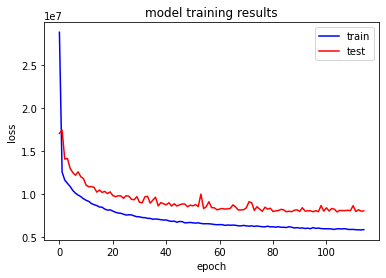

In [28]:
plot_metrics(history,"loss")

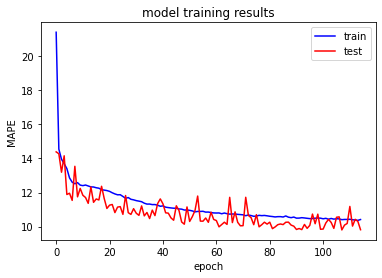

In [29]:
plot_metrics(history,"MAPE")

In [30]:
bigger_embed_model.save("bigger_embed.h5")

In [37]:
regression_metrics(bigger_embed_model,train_input,y_train,test_input,y_test,256)

r2_score         rmse  price_diff_abs_max
train  0.944789  2317.732568          559.699650
test   0.937352  2414.391473          300.850962

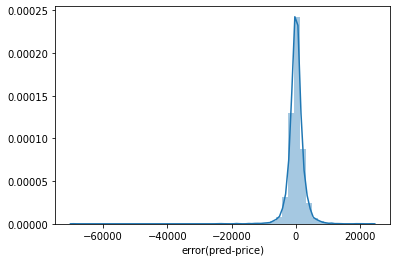

In [38]:
plot_pred_price(bigger_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [39]:
price_diff(bigger_embed_model,X_test,y_test,256, 1, test_input).sort_values("price_diff_abs",ascending=False).head(20)

model transmission fuelType  binned_year  mil_cat  binned_mpg  \
39978     A Class       Manual   Petrol            1        5           1   
40171     A Class    Automatic   Petrol            1        4           2   
12301        Golf       Manual   Petrol            2        4           2   
20056      Beetle       Manual   Petrol            1        4           2   
2450        Yaris    Automatic   Petrol            0        4           2   
85142          Z4    Automatic   Petrol            1        4           1   
98626          TT       Manual   Petrol            1        5           1   
98752          A6    Automatic   Diesel            2        4           2   
88451    3 Series       Manual   Petrol            1        5           1   
52118      Zafira       Manual   Petrol            0        3           2   
41293       Corsa       Manual   Diesel            2        4           4   
6238        Prius    Automatic   Hybrid            1        3           4   
39953         SLK    Automatic   Petrol            0        5           1   
71817       Focus       Manual   Petrol            1        5           1   
40321   CLS Class    Automatic   Petrol            3        3           1   
87143    5 Series       Manual   Petrol            0        4           1   
68392      Fiesta       Manual   Diesel            2        4           4   
37663     C Class    Semi-Auto   Diesel            2        4           4   
22009       Fabia       Manual   Diesel            2        4           4   
11911        Golf       Manual   Petrol            2        3           2   

       engine_binned  price_diff_pct  price_diff_abs  
39978              0     -300.850962      300.850962  
40171              0     -230.342041      230.342041  
12301              0     -163.496094      163.496094  
20056              0     -153.933049      153.933049  
2450               0      144.315531      144.315531  
85142              1     -137.708641      137.708641  
98626              0     -131.463641      131.463641  
98752              1     -120.849722      120.849722  
88451              1      -98.611339       98.611339  
52118              0       98.167737       98.167737  
41293              0      -95.944627       95.944627  
6238               0      -93.648183       93.648183  
39953              1       91.892615       91.892615  
71817              0      -89.920265       89.920265  
40321              1      -86.525893       86.525893  
87143              0       84.757501       84.757501  
68392              0      -81.131508       81.131508  
37663              1      -80.835349       80.835349  
22009              0      -80.402994       80.402994  
11911              0      -77.886129       77.886129

### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [9]:
EMBED_COLS = ["model","transmission","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [10]:
train_input_2,dev_input_2,test_input_2 = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [12]:
all_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [13]:
all_embed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [14]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=10,verbose=1,restore_best_weights=True)

In [16]:
# history = all_embed_model.fit(train_input_2,y_train, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
#                               validation_data=(dev_input_2,y_dev),callbacks=[earlystop])

In [17]:
all_embed_model = tfk.models.load_model("All_embed.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [20]:
regression_metrics(all_embed_model,train_input_2,y_train,test_input_2,y_test,256)

r2_score         rmse  price_diff_abs_max
train  0.946415  2283.333531          502.005809
test   0.939695  2368.801219          274.129019

In [21]:
price_diff(all_embed_model,X_test,y_test,256, 1, test_input_2).sort_values("price_diff_abs",ascending=False).head(20)

model transmission fuelType  binned_year  mil_cat  binned_mpg  \
39978    A Class       Manual   Petrol            1        5           1   
71817      Focus       Manual   Petrol            1        5           1   
20056     Beetle       Manual   Petrol            1        4           2   
12301       Golf       Manual   Petrol            2        4           2   
40171    A Class    Automatic   Petrol            1        4           2   
98752         A6    Automatic   Diesel            2        4           2   
87143   5 Series       Manual   Petrol            0        4           1   
85142         Z4    Automatic   Petrol            1        4           1   
98626         TT       Manual   Petrol            1        5           1   
41293      Corsa       Manual   Diesel            2        4           4   
39346        CLK    Automatic   Diesel            1        5           1   
69602     Mondeo       Manual   Diesel            2        5           4   
39302        CLK    Automatic   Diesel            1        5           1   
39937    S Class    Automatic   Diesel            2        3           2   
68392     Fiesta       Manual   Diesel            2        4           4   
71370     Mondeo       Manual   Petrol            2        3           1   
86317   3 Series    Automatic   Diesel            2        4           3   
87758   3 Series       Manual   Diesel            1        5           2   
22009      Fabia       Manual   Diesel            2        4           4   
65096      Focus    Semi-Auto   Petrol            3        0           2   

       engine_binned  price_diff_pct  price_diff_abs  
39978              0     -274.129019      274.129019  
71817              0     -217.754051      217.754051  
20056              0     -181.031006      181.031006  
12301              0     -152.842469      152.842469  
40171              0     -148.753988      148.753988  
98752              1     -136.591413      136.591413  
87143              0     -134.362297      134.362297  
85142              1     -122.942038      122.942038  
98626              0     -113.364945      113.364945  
41293              0     -109.017778      109.017778  
39346              1       87.587923       87.587923  
69602              0      -86.408547       86.408547  
39302              1       86.008958       86.008958  
39937              1      -84.988423       84.988423  
68392              0      -83.360206       83.360206  
71370              0      -83.022162       83.022162  
86317              0      -82.137137       82.137137  
87758              0      -80.199889       80.199889  
22009              0      -79.463257       79.463257  
65096              0      -76.839230       76.839230

### Slightly improved, still have same issues with older year. Let's import original raw data

In [9]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv").drop("brand",axis=1)
features_raw, y_raw = data_raw.drop("price",axis=1), data_raw.price
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features_raw,y_raw,test_size=0.1,random_state=2020)
X_train_r,X_dev_r,y_train_r,y_dev_r = train_test_split(X_train_r,y_train_r,test_size=0.11,random_state=2020)

In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99186 non-null  object 
 1   year          99186 non-null  int64  
 2   price         99186 non-null  int64  
 3   transmission  99186 non-null  object 
 4   mileage       99186 non-null  int64  
 5   fuelType      99186 non-null  object 
 6   mpg           99186 non-null  float64
 7   engineSize    99186 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [25]:
EMBED_COLS = ["model","transmission","fuelType","year"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [26]:
train_input_r,dev_input_r,test_input_r = cate_embed_process(X_train_r,X_dev_r,X_test_r,EMBED_COLS)

In [69]:
embed_model_r = embed_model_setup(EMBED_COLS,X_train_r,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [70]:
embed_model_r.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [72]:
history = embed_model_r.fit(train_input_r,y_train_r, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_r,y_dev_r),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11602159.0000 - MAPE: 13.0460 - MAE: 2055.5625 - val_loss: 13542245.0000 - val_MAPE: 11.1282 - val_MAE: 1916.1840
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10878559.0000 - MAPE: 12.7091 - MAE: 2010.8667 - val_loss: 13436316.0000 - val_MAPE: 11.6855 - val_MAE: 1959.7429
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 12103861.0000 - MAPE: 14.0727 - MAE: 2156.0383 - val_loss: 16170404.0000 - val_MAPE: 12.0610 - val_MAE: 2134.7617
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10933633.0000 - MAPE: 12.8544 - MAE: 2020.1902 - val_loss: 12826539.0000 - val_MAPE: 11.2397 - val_MAE: 1909.5880
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10328549.0000 - MAPE: 12.3505 - MAE: 1966.8793 - val_loss: 13079386.0000 - val_MAPE: 13.0791 - val_MAE: 2084.2996
Epoch 6/1000
2483/2483 [================

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7459500.0000 - MAPE: 11.5183 - MAE: 1783.5005 - val_loss: 12291742.0000 - val_MAPE: 12.3613 - val_MAE: 2095.4216
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7257532.0000 - MAPE: 11.2814 - MAE: 1765.1752 - val_loss: 9633478.0000 - val_MAPE: 10.4813 - val_MAE: 1782.0106
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7533823.0000 - MAPE: 11.5398 - MAE: 1791.3074 - val_loss: 9040222.0000 - val_MAPE: 11.2425 - val_MAE: 1737.6102
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7067526.5000 - MAPE: 11.0437 - MAE: 1735.6019 - val_loss: 8552214.0000 - val_MAPE: 10.1739 - val_MAE: 1664.0557
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7473866.5000 - MAPE: 11.3189 - MAE: 1761.5614 - val_loss: 8784871.0000 - val_MAPE: 11.0562 - val_MAE: 1744.3499
Epoch 49/1000
2483/2483 [===================

In [73]:
embed_model_r.save("model_embed_raw.h5")

In [23]:
embed_model_r = tfk.models.load_model("model_embed_raw.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [27]:
regression_metrics(embed_model_r,train_input_r,y_train_r,test_input_r,y_test_r,256)

r2_score         rmse  price_diff_abs_max
train  0.937795  2460.156655          839.927122
test   0.933197  2493.158267          161.217717

In [28]:
price_diff(embed_model_r,X_train_r,y_train_r,256, 1, train_input_r).sort_values("price_diff_abs",ascending=False).head(20)

model  year transmission  mileage fuelType   mpg  engineSize  \
11984        Golf  2008       Manual        1   Diesel  53.3         1.9   
71819      Mondeo  2008       Manual        1   Diesel  47.9         2.0   
47201       Astra  2001       Manual   159000   Petrol  40.4         1.6   
20061      Beetle  2001    Automatic        1   Petrol  29.7         2.0   
44539       Corsa  2002       Manual    99842   Petrol  50.4         1.0   
44573       Corsa  2002       Manual    85000   Petrol  44.8         1.2   
83274          Z4  2014       Manual    31074   Petrol  41.5         2.0   
39711     C Class  2002    Automatic    13800   Diesel  39.8         2.7   
2447        Yaris  2002       Manual   104000   Petrol  40.4         1.5   
78800          X3  2013    Semi-Auto    26000   Diesel  50.4         2.0   
29517   GLE Class  2016    Semi-Auto    77456   Diesel  42.8         3.0   
39336     S Class  2001    Automatic   108800   Diesel  31.7         3.2   
52127      Zafira  2002       Manual   105000   Petrol  35.8         1.6   
69280      Mondeo  2002       Manual   136784   Petrol  36.2         1.8   
40173     S Class  1999    Automatic    34000   Petrol  24.6         3.2   
40172     S Class  2002    Automatic    24000   Petrol  21.1         5.0   
89219          Q7  2016    Semi-Auto    26705   Diesel  47.9         3.0   
12343      Passat  2014    Automatic       80   Diesel  54.3         2.0   
40170     A Class  2010       Manual   116126   Diesel  54.3         2.0   
5496         Aygo  2005       Manual    88836   Petrol  61.4         1.0   

       price_diff_pct  price_diff_abs  
11984     -839.927122      839.927122  
71819     -637.334759      637.334759  
47201      556.738770      556.738770  
20061     -510.034315      510.034315  
44539      496.373698      496.373698  
44573      359.889056      359.889056  
83274     -356.550874      356.550874  
39711     -303.523268      303.523268  
2447       275.393478      275.393478  
78800     -244.616209      244.616209  
29517     -221.892540      221.892540  
39336     -205.550274      205.550274  
52127      202.183152      202.183152  
69280      189.918752      189.918752  
40173     -189.523073      189.523073  
40172     -174.377988      174.377988  
89219     -172.167375      172.167375  
12343     -167.717327      167.717327  
40170     -164.982765      164.982765  
5496       163.229589      163.229589

### Let's use numeric binned data instead

In [11]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)

In [12]:
features_c, y_c = combined.drop("price",axis=1), combined.price
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_c,y_c,test_size=0.1,random_state=2020)
X_train_c,X_dev_c,y_train_c,y_dev_c = train_test_split(X_train_c,y_train_c,test_size=0.11,random_state=2020)

In [13]:
EMBED_COLS = ["model","transmission","fuelType","year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [14]:
train_input_c,dev_input_c,test_input_c = cate_embed_process(X_train_c,X_dev_c,X_test_c,EMBED_COLS)

In [15]:
embed_model_c = embed_model_setup(EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [16]:
embed_model_c.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [18]:
history = embed_model_c.fit(train_input_c,y_train_c, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_c,y_dev_c),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 9s 4ms/step - loss: 31603832.0000 - MAPE: 20.8560 - MAE: 3091.8372 - val_loss: 18940896.0000 - val_MAPE: 15.8726 - val_MAE: 2422.2217
Epoch 2/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 13292170.0000 - MAPE: 14.9050 - MAE: 2212.7520 - val_loss: 15015976.0000 - val_MAPE: 14.5079 - val_MAE: 2233.5239
Epoch 3/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 10300336.0000 - MAPE: 12.4294 - MAE: 1918.9307 - val_loss: 12631642.0000 - val_MAPE: 11.9779 - val_MAE: 1897.4580
Epoch 4/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 9416839.0000 - MAPE: 11.5686 - MAE: 1835.0997 - val_loss: 12167667.0000 - val_MAPE: 11.4486 - val_MAE: 1894.4714
Epoch 5/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 8942123.0000 - MAPE: 11.1076 - MAE: 1794.1338 - val_loss: 11222325.0000 - val_MAPE: 10.3661 - val_MAE: 1770.2841
Epoch 6/1000
2483/2483 [==================

2483/2483 [==============================] - 8s 3ms/step - loss: 5206872.0000 - MAPE: 9.2580 - MAE: 1485.9766 - val_loss: 7387585.5000 - val_MAPE: 8.8096 - val_MAE: 1467.2712
Epoch 45/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5167671.0000 - MAPE: 9.2732 - MAE: 1489.2797 - val_loss: 7412171.0000 - val_MAPE: 9.6309 - val_MAE: 1532.3092
Epoch 46/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5152824.0000 - MAPE: 9.2494 - MAE: 1482.8665 - val_loss: 7522205.5000 - val_MAPE: 8.7960 - val_MAE: 1485.2932
Epoch 47/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5170481.5000 - MAPE: 9.2219 - MAE: 1480.5929 - val_loss: 7391446.5000 - val_MAPE: 8.9273 - val_MAE: 1478.7384
Epoch 48/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5161470.5000 - MAPE: 9.1854 - MAE: 1477.0105 - val_loss: 7501253.5000 - val_MAPE: 8.6837 - val_MAE: 1474.0347
Epoch 49/1000
2483/2483 [==============================] - 9s 3ms/ste

In [19]:
embed_model_c.save("combined_embed_all.h5")

In [20]:
regression_metrics(embed_model_c,train_input_c,y_train_c,test_input_c,y_test_c,256)

r2_score         rmse  price_diff_abs_max
train  0.954038  2114.703573          439.518793
test   0.948263  2194.083886          170.213623

In [21]:
price_diff(embed_model_c,X_train_c,y_train_c,256, 1, train_input_c).sort_values("price_diff_abs",ascending=False).head(20)

model transmission fuelType  mil_cat  binned_mpg  engine_binned  \
11984        Golf       Manual   Diesel        0           3              0   
71819      Mondeo       Manual   Diesel        0           2              0   
71617      Fiesta       Manual   Petrol        4           2              0   
83274          Z4       Manual   Petrol        3           2              0   
20061      Beetle    Automatic   Petrol        0           1              0   
39540     M Class    Semi-Auto   Petrol        5           1              1   
69135      Mondeo       Manual   Diesel        4           2              0   
87481    3 Series    Automatic   Petrol        4           1              1   
77582    Santa Fe       Manual   Petrol        4           1              1   
40170     A Class       Manual   Diesel        5           3              0   
78800          X3    Semi-Auto   Diesel        2           3              0   
29517   GLE Class    Semi-Auto   Diesel        4           2              1   
39711     C Class    Automatic   Diesel        2           1              1   
52100      Zafira       Manual   Diesel        5           3              0   
39926         SLK    Automatic   Petrol        4           1              1   
13060      Passat       Manual   Diesel        5           3              0   
15458        Polo       Manual   Petrol        1           3              0   
89219          Q7    Semi-Auto   Diesel        2           2              1   
44309       Corsa       Manual   Diesel        5           4              0   
289       Corolla    Automatic   Petrol        4           1              0   

       year  price_diff_pct  price_diff_abs  
11984  2008     -439.518793      439.518793  
71819  2008     -438.775282      438.775282  
71617  2008     -351.201284      351.201284  
83274  2014     -304.856875      304.856875  
20061  2001     -284.588127      284.588127  
39540  2004     -267.137546      267.137546  
69135  2005     -257.123843      257.123843  
87481  1999     -255.345785      255.345785  
77582  2002     -231.388367      231.388367  
40170  2010     -209.049298      209.049298  
78800  2013     -196.691243      196.691243  
29517  2016     -195.415902      195.415902  
39711  2002     -190.480083      190.480083  
52100  2013     -177.042661      177.042661  
39926  1998     -171.264158      171.264158  
13060  2010     -170.198187      170.198187  
15458  2019     -163.633629      163.633629  
89219  2016     -160.526906      160.526906  
44309  2010     -159.995036      159.995036  
289    2001     -158.491097      158.491097

### The binned numeric value did better than original numerica data. 